#### Assessing Marketplace Accessibility: Isochrones for Marketplaces and Supermarkets in Quezon City

Janssens & Sezer (2013). Marketplaces as an Urban Development Strategy (Editorial). Built Environment, 39: 10.2148/benv.39.2.169

Markets act as:
- commercial gathering places
- vivid & inclusive public spaces
- nexus of flows of people, goods, and information
- sources of: 
    - fresh & affordable food, 
    - economic opportunities, and 
    - chances to socialize
- engines for sustainable urban growth
- sites to get a pulse of a city
- domains of public discontent & dispute
- sites of congestion, chaos, illegality
- romantic images for late capitalist urban gentrification
- centers of social movements and grassroots initiatives

#### Where the Jobs Are: Analysis of Office Density in Metro Manila

##### Research Questions:
- What is the distribution of office buildings in Metro Manila?
- What are the dominant clusters of office space in Metro Manila?
- How much office space is there per city in Metro Manila?

Step 0: Set Up Workspace

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as cx

In [2]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

Step 1: Data Acquisition

To start, we will first extract all map features with an `office` tag.

In [3]:
# Define place name as Metro Manila
PLACE_NAME = ("Metro Manila, Philippines")

In [4]:
# # Extract Metro Manila boundary polygon
# area = ox.geocode_to_gdf(PLACE_NAME)
# area

In [5]:
# area.plot()

In [6]:
# Extract all offices in Metro Manila
offices = ox.features_from_place(
    PLACE_NAME,
    {
        "building": "office"
    }
)

In [7]:
offices.head()

geometry    addr:city  \
element_type osmid                                                 
node         255065944   POINT (121.05380 14.65982)  Quezon City   
             1376396819  POINT (121.03672 14.64318)          NaN   
             2750034536  POINT (121.04494 14.77467)     Caloocan   
             2930591938  POINT (121.06998 14.66294)          NaN   
             3076096417  POINT (121.04453 14.65356)          NaN   

                        addr:postcode building garmin:description  \
element_type osmid                                                  
node         255065944           1100   office           building   
             1376396819           NaN   office                NaN   
             2750034536           NaN   office                NaN   
             2930591938          1119   office                NaN   
             3076096417          1101   office                NaN   

                                                                  name  \
element_type osmid                                                       
node         255065944                       Campus Landscaping Office   
             1376396819                                            NaN   
             2750034536            Bagong Silang Phase 1 Barangay Hall   
             2930591938               Konstruktura Centro Incorporated   
             3076096417  Mines and Geosciences Bureau - Central Office   

                          amenity wheelchair          description  \
element_type osmid                                                  
node         255065944        NaN        NaN                  NaN   
             1376396819   shelter        NaN  Commercial Building   
             2750034536  townhall        NaN                  NaN   
             2930591938       NaN        NaN   General Contractor   
             3076096417       NaN        NaN    government office   

                            shelter_type  ... architect addr:place  \
element_type osmid                        ...                        
node         255065944               NaN  ...       NaN        NaN   
             1376396819  weather_shelter  ...       NaN        NaN   
             2750034536              NaN  ...       NaN        NaN   
             2930591938              NaN  ...       NaN        NaN   
             3076096417              NaN  ...       NaN        NaN   

                        evacuation_center fixme owner addr:quarter ways type  \
element_type osmid                                                             
node         255065944                NaN   NaN   NaN          NaN  NaN  NaN   
             1376396819               NaN   NaN   NaN          NaN  NaN  NaN   
             2750034536               NaN   NaN   NaN          NaN  NaN  NaN   
             2930591938               NaN   NaN   NaN          NaN  NaN  NaN   
             3076096417               NaN   NaN   NaN          NaN  NaN  NaN   

                        police building:architecture  
element_type osmid                                    
node         255065944     NaN                   NaN  
             1376396819    NaN                   NaN  
             2750034536    NaN                   NaN  
             2930591938    NaN                   NaN  
             3076096417    NaN                   NaN  

[5 rows x 111 columns]

Next, let us examine the data and see which information is most relevant. We can drop the columns we don't need.

In [8]:
offices.shape

(528, 111)

In [9]:
offices.columns.values

array(['geometry', 'addr:city', 'addr:postcode', 'building',
       'garmin:description', 'name', 'amenity', 'wheelchair',
       'description', 'shelter_type', 'addr:province', 'addr:street',
       'government', 'office', 'opening_hours', 'townhall:type',
       'addr:housenumber', 'source', 'alt_name', 'old_name',
       'addr:housename', 'addr:street:corner', 'historic', 'start_date',
       'wikidata', 'wikimedia_commons', 'landuse', 'admin_level',
       'check_date', 'name:en', 'int_name', 'nodes', 'building:levels',
       'building:colour', 'building:material', 'height', 'name:tl',
       'website', 'note', 'short_name', 'wikipedia', 'postal_code',
       'branch', 'company', 'phone', 'smoking', 'addr:floor', 'email',
       'fax', 'roof:shape', 'building:levels:underground', 'country',
       'diplomatic', 'embassy', 'name:fr', 'target', 'official_name',
       'addr:village', 'layer', 'name:acronym', 'building:part',
       'healthcare', 'mapillary', 'operator:type', 'ref:do

In [10]:
offices.isna().sum()

geometry                   0
addr:city                236
addr:postcode            387
building                   0
garmin:description       526
                        ... 
addr:quarter             527
ways                     516
type                     516
police                   527
building:architecture    527
Length: 111, dtype: int64

In [11]:
offices["nodes"].isna().sum()

16

In [12]:
na_cutoff = len(offices) * 0.75

In [13]:
drop_cols = []

for col in offices:
    if offices[col].isna().sum() >= na_cutoff:
        drop_cols.append(col)

offices.drop(columns=drop_cols, inplace=True)

In [14]:
offices.columns.values

array(['geometry', 'addr:city', 'addr:postcode', 'building', 'name',
       'addr:street', 'nodes', 'building:levels', 'height'], dtype=object)

In [15]:
offices.isna().sum()

geometry             0
addr:city          236
addr:postcode      387
building             0
name                67
addr:street        262
nodes               16
building:levels    169
height             245
dtype: int64

In [16]:
offices.head()

geometry    addr:city  \
element_type osmid                                                 
node         255065944   POINT (121.05380 14.65982)  Quezon City   
             1376396819  POINT (121.03672 14.64318)          NaN   
             2750034536  POINT (121.04494 14.77467)     Caloocan   
             2930591938  POINT (121.06998 14.66294)          NaN   
             3076096417  POINT (121.04453 14.65356)          NaN   

                        addr:postcode building  \
element_type osmid                               
node         255065944           1100   office   
             1376396819           NaN   office   
             2750034536           NaN   office   
             2930591938          1119   office   
             3076096417          1101   office   

                                                                  name  \
element_type osmid                                                       
node         255065944                       Campus Landscaping Office   
             1376396819                                            NaN   
             2750034536            Bagong Silang Phase 1 Barangay Hall   
             2930591938               Konstruktura Centro Incorporated   
             3076096417  Mines and Geosciences Bureau - Central Office   

                              addr:street nodes building:levels height  
element_type osmid                                                      
node         255065944                NaN   NaN             NaN    NaN  
             1376396819               NaN   NaN             NaN    NaN  
             2750034536  Old Zabarte Road   NaN             NaN    NaN  
             2930591938            Road 1   NaN             NaN    NaN  
             3076096417      North Avenue   NaN             NaN    NaN

Let us plot the offices on a map to see what we have. But first, let's ensure that the CRS is pseudo-mercator for web-mapping.

In [17]:
offices.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
offices.to_crs("EPSG:3857", inplace=True)

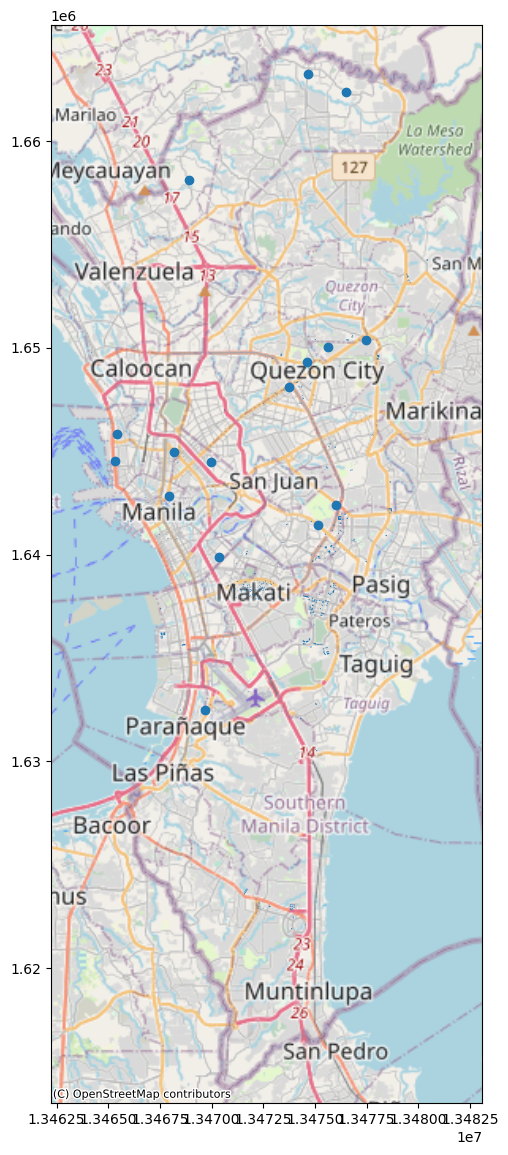

In [19]:
ax = offices.plot(
    figsize=(8,14),
    legend=True
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

In [20]:
# Get coordinates of office points
coords = offices.get_coordinates()
coords

x             y
element_type osmid                                 
node         255065944   1.347565e+07  1.650026e+06
             1376396819  1.347375e+07  1.648112e+06
             2750034536  1.347466e+07  1.663246e+06
             2930591938  1.347745e+07  1.650386e+06
             3076096417  1.347462e+07  1.649307e+06
...                               ...           ...
relation     14885963    1.346661e+07  1.642174e+06
             14885963    1.346661e+07  1.642178e+06
             14885963    1.346661e+07  1.642181e+06
             14885963    1.346660e+07  1.642177e+06
             14885963    1.346661e+07  1.642174e+06

[4287 rows x 2 columns]

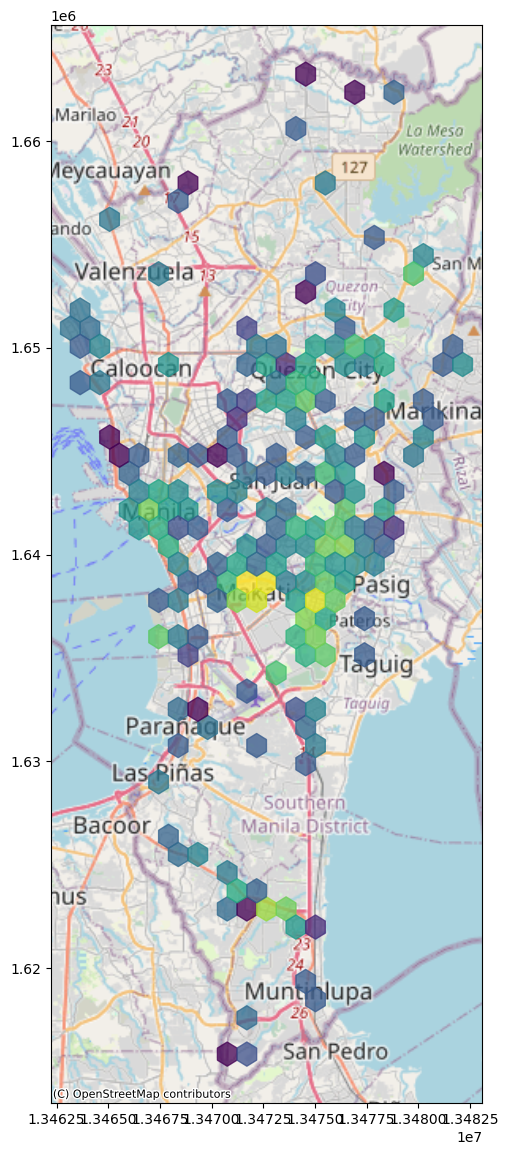

In [25]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,14))

ax2.hexbin(
    coords.x,
    coords.y,
    gridsize=(20, 27),
    bins="log",
    alpha=0.75
)
cx.add_basemap(ax2, source=cx.providers.OpenStreetMap.Mapnik)